In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

import matplotlib
matplotlib.style.use('seaborn')

In [3]:
from draftbot import Draft

In [4]:
import json

card_values = pd.DataFrame(json.load(open('../data/m19/m19-custom-card-values-reduced.json'))).T

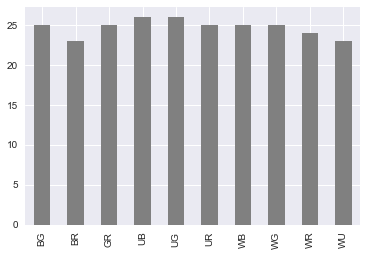

In [5]:
card_values.sum().plot.bar(color='grey')

In [6]:
draft = Draft(cards_path='../data/m19/m19-subset-reduced.json',
              card_values_path='../data/m19/m19-custom-card-values-reduced.json')
draft.draft()

## New Module Code...

In [7]:
from draftbot.plotting import DraftPlotter

In [8]:
dp = DraftPlotter(draft=draft)

(<Figure size 1152x1728 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x127f80d68>,
       dtype=object))

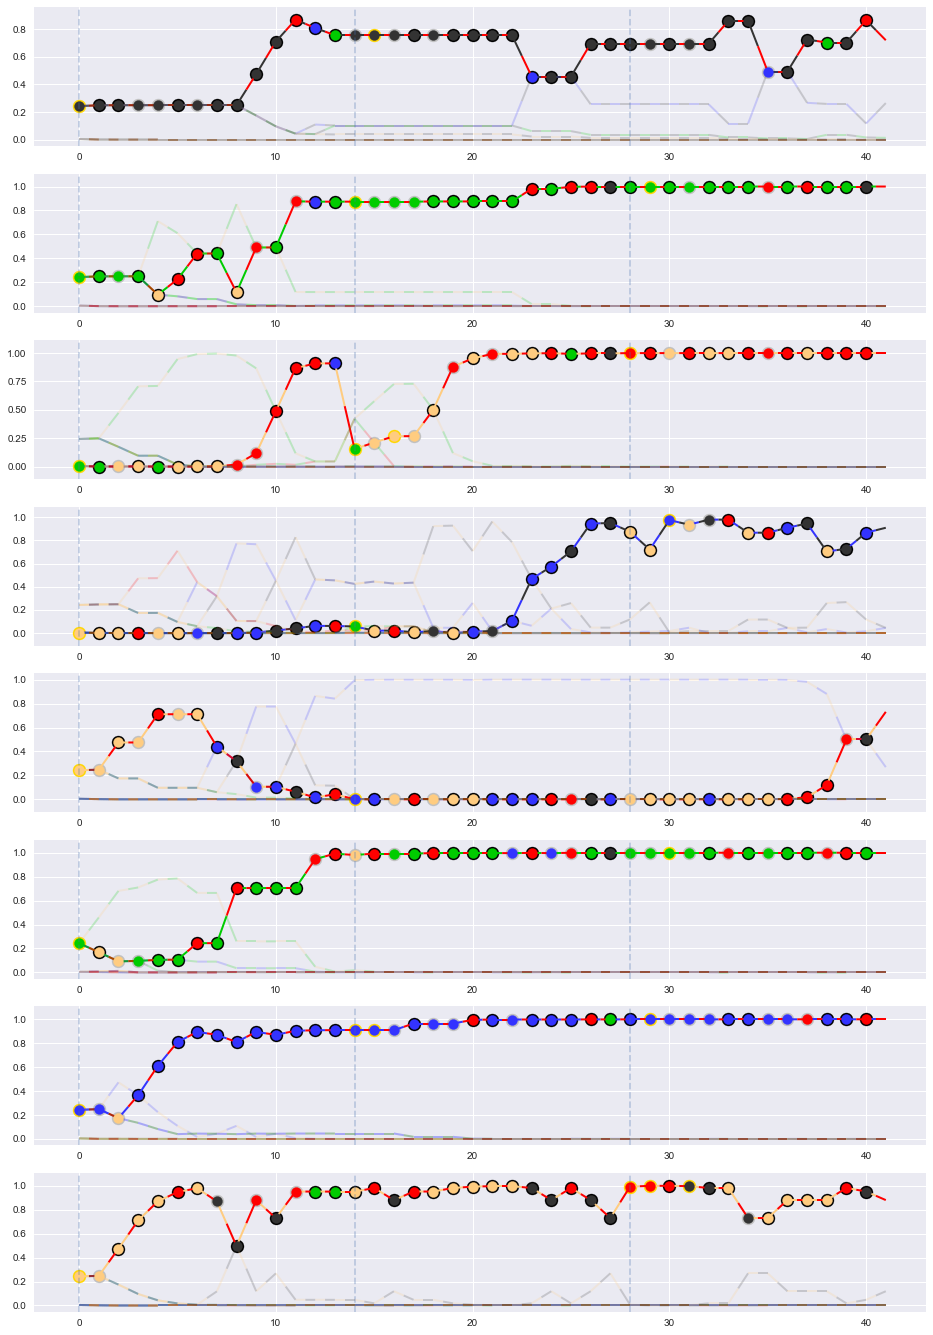

In [11]:
dp.plot_draft_history()

## Assemble Some More Convenient Data Structures

In [9]:
preferences_history_dfs = []

for drafter_idx in range(draft.n_drafters):
    preferences_history_dfs.append(
        pd.DataFrame(
            draft.preferences[drafter_idx, :, :].T,
            columns=draft.archetype_names))

In [10]:
cards_picked = []
for i in range(8):
    df = pd.DataFrame(draft.picks[i, :, :].astype(int).T, columns=draft.card_names)
    cards_picked.append(df.idxmax(axis=1))

## Plotting Code

In [7]:
def make_archytype_color_mapping(alpha):
    arch_color_mapping = {
        'W': [1, 0.8, 0.5, alpha],
        'U': [0.2, 0.2, 1, alpha],
        'B': [0.2, 0.2, 0.2, alpha],
        'R': [1, 0, 0, alpha],
        'G': [0, 0.8, 0, alpha]
    }
    return arch_color_mapping

rarity_color_mapping = {
    'common': [0.0, 0.0, 0.0],
    'uncommon': [192 / 255, 192 / 255, 192 / 255],
    'rare': [255 / 255, 215 / 255, 0],
    'mythic': [255 / 255, 140 / 255, 0],    
}

def make_archytype_colors(arch, alpha=1):
    arch_color_mapping = make_archytype_color_mapping(alpha)
    return [arch_color_mapping[c] for c in arch]

card_color_mapping = {
    card['name']: card['colorIdentity'] for card in draft.set.cards
}

card_rarity_mapping = {
    card['name']: card['rarity'] for card in draft.set.cards
}

In [8]:
def plot_alternating_color_line(ax, x, y, colors):
    x, y = insert_middpoints(x.astype(float)), insert_middpoints(y.astype(float))
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    segment_boundaries = insert_middpoints(np.arange(x.min(), x.max() + 1))
    n_bins = len(segment_boundaries) - 1
    cmap = ListedColormap((colors*n_bins)[:n_bins])
    norm = BoundaryNorm(segment_boundaries, cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(x)
    lc.set_linewidth(2)
    ax.add_collection(lc)

def insert_middpoints(arr):
    midpoints = (arr[:-1] + arr[1:]) / 2
    return np.insert(arr, np.arange(1, len(arr)), midpoints)

In [9]:
def plot_color_identity_dot(ax, x, y, color_identity, s=100, alpha=1.0):
    arch_color_mapping = make_archytype_color_mapping(alpha)
    colors = [arch_color_mapping[c] for c in color_identity]
    if len(colors) == 0:
        ax.scatter(x, y, c=['grey'], s=s, zorder=2)
    if len(colors) == 1:
        ax.scatter(x, y, c=[colors[0]], s=s, zorder=2)
    if len(colors) >= 2:
        plot_multi_color_dot(ax, x, y, colors)

def plot_multi_color_dot(ax, x, y, colors, s=100):
    angles = list(np.linspace(start=0, stop=2*np.pi, num=(len(colors) + 1)))
    begin_angles = angles[:-1]
    end_angles = angles[1:]
    for angle, end_angle, color in zip(begin_angles, end_angles, colors):
        xs = [0] + np.sin(np.linspace(angle, end_angle, 25)).tolist()
        ys = [0] + np.cos(np.linspace(angle, end_angle, 25)).tolist()
        xy = np.column_stack([xs, ys])
        ax.scatter(x, y, marker=xy, s=s, facecolor=color, zorder=2)

In [10]:
def softmax(df):
    return pd.DataFrame(
         np.exp(df).values / np.exp(df).sum(axis=1).values.reshape(-1, 1),
         columns=df.columns)

def normalize(df):
    return pd.DataFrame(
        df.values / df.sum(axis=1).values.reshape(-1, 1),
        columns=df.columns)

In [11]:
def plot_history_lines(ax, 
                       history_df, 
                       normalization_function=softmax, 
                       winning_archytype=None):
    history_df = normalization_function(history_df)
    if not winning_archytype:
        winning_archytype = history_df.iloc[-1, :].idxmax()
    winning_history = history_df.loc[:, winning_archytype]
    
    colors = make_archytype_colors(winning_archytype, alpha=1.0)
    plot_alternating_color_line(
        ax, 
        winning_history.index.values, 
        winning_history.values, 
        colors)
    
    for arch in set(history_df.columns) - set([winning_archytype]):
        arch_history = history_df.loc[:, arch]
        colors = make_archytype_colors(arch, alpha=0.2)
        plot_alternating_color_line(
            ax,
            arch_history.index.values,
            arch_history.values, colors)
    
    return winning_archytype, winning_history

def plot_drafter_history(ax,
                         history_df,
                         cards_picked,
                         normalization_function=softmax):
    
    winning_archytype, winning_history = plot_history_lines(
        ax,
        history_df,
        normalization_function=normalization_function)
    
    card_rarities = [card_rarity_mapping[card] for card in cards_picked]
    card_colors = [card_color_mapping[card] for card in cards_picked]
    dot_data = zip(
        card_colors, 
        card_rarities, 
        winning_history.index.values,
        winning_history.values[:-1])
    for pick_num, (color_pair, rarity, x, y) in enumerate(dot_data):
        ax.scatter(x, y, s=170, c=[rarity_color_mapping[rarity]])
        plot_color_identity_dot(ax, x, y, color_pair)
        if pick_num % 14 == 0:
            ax.axvline(pick_num, linestyle='--', alpha=0.3)
    
    return winning_archytype, winning_history

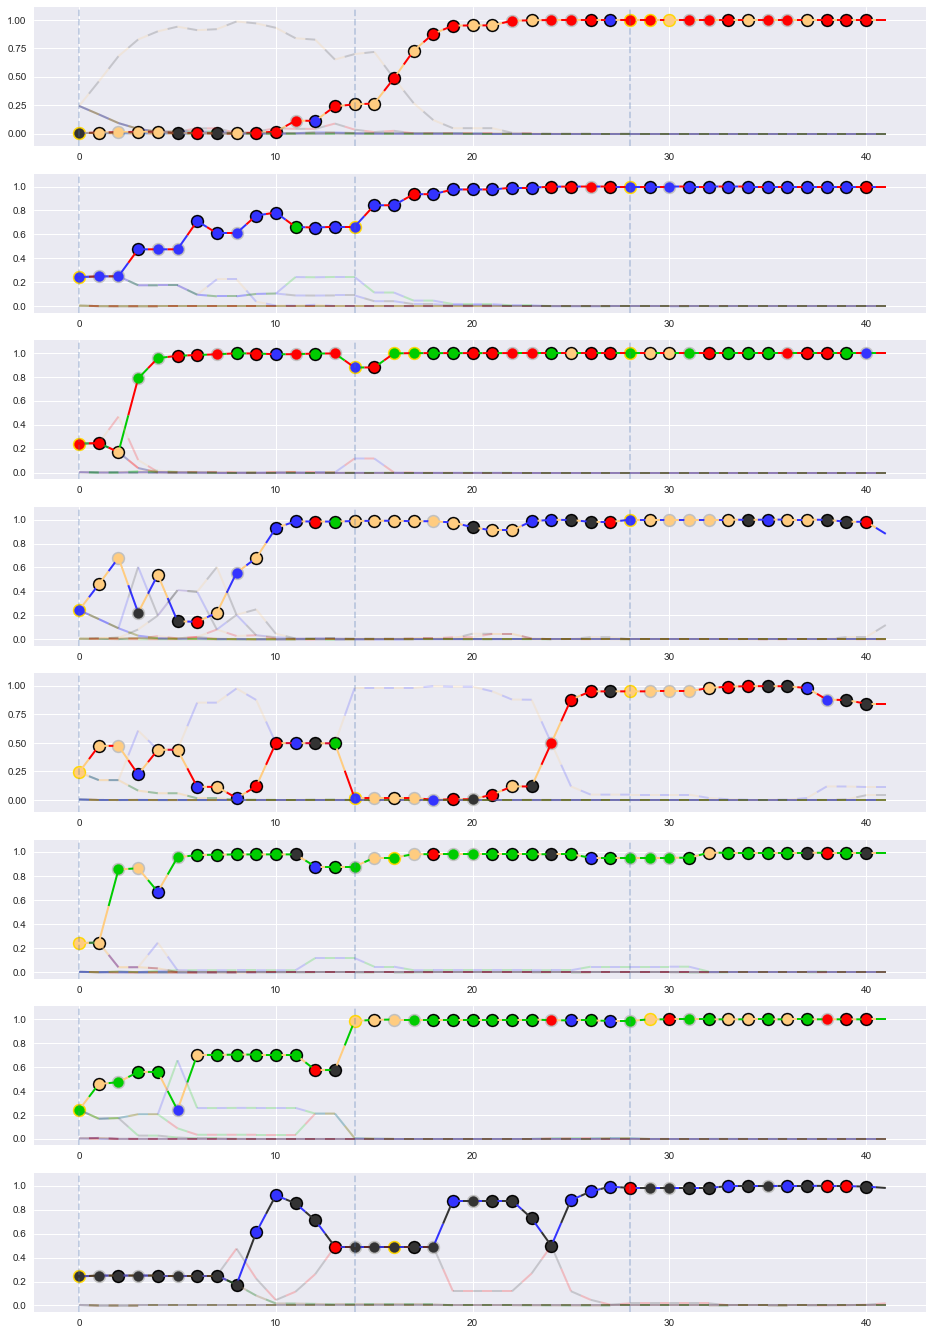

In [12]:
fig, axs = plt.subplots(draft.n_drafters, figsize=(16, draft.n_drafters * 3))

for ax, preferences_history, cards in zip(axs, preferences_history_dfs, cards_picked):
    plot_drafter_history(ax,
                         preferences_history,
                         cards,
                         normalization_function=softmax)

In [13]:
cards_picked[7]

0     Demon of Catastrophes
1                    Murder
2             Lich's Caress
3                    Murder
4             Lich's Caress
5                    Murder
6             Lich's Caress
7      Skymarch Bloodletter
8          Doomed Dissenter
9           Essence Scatter
10          Essence Scatter
11         Doomed Dissenter
12         Doomed Dissenter
13      Viashino Pyromancer
14                   Murder
15                   Murder
16    Demon of Catastrophes
17            Lich's Caress
18                   Murder
19      Salvager of Secrets
20                   Murder
21            Lich's Caress
22     Skymarch Bloodletter
23         Doomed Dissenter
24         Doomed Dissenter
25          Essence Scatter
26         Aviation Pioneer
27          Essence Scatter
28                Electrify
29                   Murder
30                   Murder
31            Lich's Caress
32            Lich's Caress
33      Salvager of Secrets
34            Lich's Caress
35                  

In [16]:
np.unique(np.array([card_color_mapping[card][0] for card in cards_picked[2]]), return_counts=True)

(array(['G', 'R', 'U', 'W'], dtype='<U1'), array([15, 20,  3,  4]))